In [41]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import matplotlib.pyplot as plt

def process_tensorboard_directory(directory_path, tag_name='eval/ret/mean'):
    """
    Process all TensorBoard event files in a directory and extract data for a specific tag.

    Parameters:
    directory_path (str): Path to the directory containing TensorBoard event files.
    tag_name (str): Tag of the data to read.

    Returns:
    list of tuples: Each tuple contains (step, value) for the entries under the specified tag.
    """
    all_data = []
    for filename in os.listdir(directory_path):
        if filename.startswith("events.out.tfevents"):
            file_path = os.path.join(directory_path, filename)
            file_data = read_tensorboard_data(file_path, tag_name)
            all_data.extend(file_data)
    return all_data

def read_tensorboard_data(log_file_path, tag_name='eval/mean_reward'):
    """
    Read specified tag data from a TensorBoard log file.

    Parameters:
    log_file_path (str): Path to the TensorBoard log file.
    tag_name (str): Tag of the data to read.

    Returns:
    list of tuples: Each tuple contains (step, value) for the entries under the specified tag.
    """
    data = []
    try:
        for e in summary_iterator(log_file_path):
            for v in e.summary.value:
                if v.tag == tag_name:
                    if v.HasField('simple_value'):
                        data.append((e.step, v.simple_value))
                    elif v.HasField('tensor'):
                        value = tf.io.decode_raw(v.tensor.tensor_content, v.tensor.dtype)
                        data.append((e.step, float(value.numpy())))
                    else:
                        print(f"Unsupported value type in {log_file_path} for tag {tag_name}")
    except Exception as ex:
        print(f"Error reading {log_file_path}: {str(ex)}")
    return data

def create_dataframe(data, step_divisor=8):
    """
    Convert list of data into a DataFrame and perform necessary transformations.

    Parameters:
    data (list of tuples): Data as a list of (step, value) tuples.
    step_divisor (int): Divisor to calculate episodes from steps.

    Returns:
    DataFrame: Processed data with added columns for transformed rewards and episodes.
    """
    df = pd.DataFrame(data, columns=['Step', 'Mean Reward'])
    df.sort_values(by='Step', inplace=True)
    df['Transformed Reward'] = 1 / np.exp(1 / df['Mean Reward'])
    df['Episodes'] = df['Step'] / step_divisor
    return df

def filter_max_performance(df, column='Transformed Reward', episode_column='Episodes', max_episode=None):
    """
    Filter out data points after the maximum performance episode.

    Parameters:
    df (DataFrame): The input data frame.
    column (str): Column to consider for maximum performance.
    episode_column (str): Column name for episodes.
    max_episode (float): Maximum episode value to consider.

    Returns:
    DataFrame: Filtered data frame.
    """
    if max_episode is None:
        max_episode = df[df[column] == df[column].max()][episode_column].values[0]
    return df[df[episode_column] <= max_episode]

def fit_linear_regression(X, y, force_intercept=False):
    """
    Fit a linear regression model.

    Parameters:
    X (Series): Predictor.
    y (Series): Response.
    force_intercept (bool): If True, force the intercept to be 0.0.

    Returns:
    OLS: Fitted model.
    """
    if force_intercept:
        X = X.values.reshape(-1, 1)  # Reshape X for sklearn
        model = sm.OLS(y, X).fit()
        model.params['const'] = 0.0  # Set intercept to 0.0
    else:
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
    return model

# Directory containing the TensorBoard files
PPO_tb_path = "/home/thomas/datacortex/tb_PPO"
dreamerv3_tb_path = "/home/thomas/datacortex/log_dreamer/logdir/12m_topopt_nostrain"
dreamer100M_tb_path = "/home/thomas/datacortex/log_dreamer/logdir/100m_topopt_nostrain"

# Process data
PPO_data = process_tensorboard_directory(PPO_tb_path, 'eval/mean_reward')
dreamerv3_data = process_tensorboard_directory(dreamerv3_tb_path, 'eval/ret/mean')
dreamer100M_data = process_tensorboard_directory(dreamer100M_tb_path, 'eval/ret/mean')

# Convert data to DataFrames
PPO_df = create_dataframe(PPO_data)
dreamerv3_df = create_dataframe(dreamerv3_data)
dreamer100M_df = create_dataframe(dreamer100M_data)

# Find maximum value for normalization across all datasets
max_value = max(PPO_df['Transformed Reward'].max(), dreamerv3_df['Transformed Reward'].max(), dreamer100M_df['Transformed Reward'].max())

# Normalize the data
PPO_df['Normalized Reward'] = PPO_df['Transformed Reward'] / max_value
dreamerv3_df['Normalized Reward'] = dreamerv3_df['Transformed Reward'] / max_value
dreamer100M_df['Normalized Reward'] = dreamer100M_df['Transformed Reward'] / max_value

# Rename columns to differentiate between PPO, Dreamer12M, and Dreamer100M
PPO_df.rename(columns={'Normalized Reward': 'Normalized PPO'}, inplace=True)
dreamerv3_df.rename(columns={'Normalized Reward': 'Normalized Dreamer12M'}, inplace=True)
dreamer100M_df.rename(columns={'Normalized Reward': 'Normalized Dreamer100M'}, inplace=True)

# Optionally filter out data points after the maximum performance episodes
cut_after_max = True  # Set to False to disable cutting after max points
if cut_after_max:
    PPO_df = filter_max_performance(PPO_df)
    dreamerv3_df = filter_max_performance(dreamerv3_df)
    dreamer100M_df = filter_max_performance(dreamer100M_df)

# Merge dataframes on Episodes
processed_merged_df = pd.merge(PPO_df[['Episodes', 'Normalized PPO']], 
                               dreamerv3_df[['Episodes', 'Normalized Dreamer12M']], 
                               on='Episodes', how='outer')
processed_merged_df = pd.merge(processed_merged_df, 
                               dreamer100M_df[['Episodes', 'Normalized Dreamer100M']], 
                               on='Episodes', how='outer')

# Display the processed DataFrame
print(PPO_df.head())
print(dreamerv3_df.head())
print(dreamer100M_df.head())
print(processed_merged_df.head())

# Fit linear regression models
force_intercept = True  # Set to True to force the intercept to 0.0
PPO_data = processed_merged_df.dropna(subset=['Normalized PPO'])
X_PPO = PPO_data['Episodes']
y_PPO = PPO_data['Normalized PPO']
model_PPO = fit_linear_regression(X_PPO, y_PPO, force_intercept)
print(model_PPO.summary())

dreamer12M_data = processed_merged_df.dropna(subset=['Normalized Dreamer12M'])
X_dreamer12M = dreamer12M_data['Episodes']
y_dreamer12M = dreamer12M_data['Normalized Dreamer12M']
model_dreamer12M = fit_linear_regression(X_dreamer12M, y_dreamer12M, force_intercept)
print(model_dreamer12M.summary())

dreamer100M_data = processed_merged_df.dropna(subset=['Normalized Dreamer100M'])
X_dreamer100M = dreamer100M_data['Episodes']
y_dreamer100M = dreamer100M_data['Normalized Dreamer100M']
model_dreamer100M = fit_linear_regression(X_dreamer100M, y_dreamer100M, force_intercept)
print(model_dreamer100M.summary())


/tmp/ipykernel_567207/845077541.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.append((e.step, float(value.numpy())))


    Step  Mean Reward  Transformed Reward  Episodes  Normalized PPO
0   4992     0.051529        3.730734e-09     624.0    1.344298e-07
1   9984     0.024071        9.074985e-19    1248.0    3.269996e-17
2  14976     0.024071        9.074985e-19    1872.0    3.269996e-17
3  19968     0.028513        5.866571e-16    2496.0    2.113905e-14
4  24960     0.014457        9.119815e-31    3120.0    3.286149e-29
       Step  Mean Reward  Transformed Reward  Episodes  Normalized Dreamer12M
955  125312     0.101431            0.000052   15664.0               0.001884
956  145216     0.105435            0.000076   18152.0               0.002739
957  165440     0.110489            0.000117   20680.0               0.004227
958  185280     0.117877            0.000207   23160.0               0.007454
959  205888     0.120711            0.000252   25736.0               0.009097
     Step  Mean Reward  Transformed Reward  Episodes  Normalized Dreamer100M
0  115776     0.139096            0.000755   14

/tmp/ipykernel_567207/3470292638.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppo_df['Predicted_PPO'] = predict_values(ppo_df, model_PPO, force_intercept)
/tmp/ipykernel_567207/3470292638.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dreamer12M_df['Predicted_Dreamer12M'] = predict_values(dreamer12M_df, model_dreamer12M, force_intercept)
/tmp/ipykernel_567207/3470292638.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

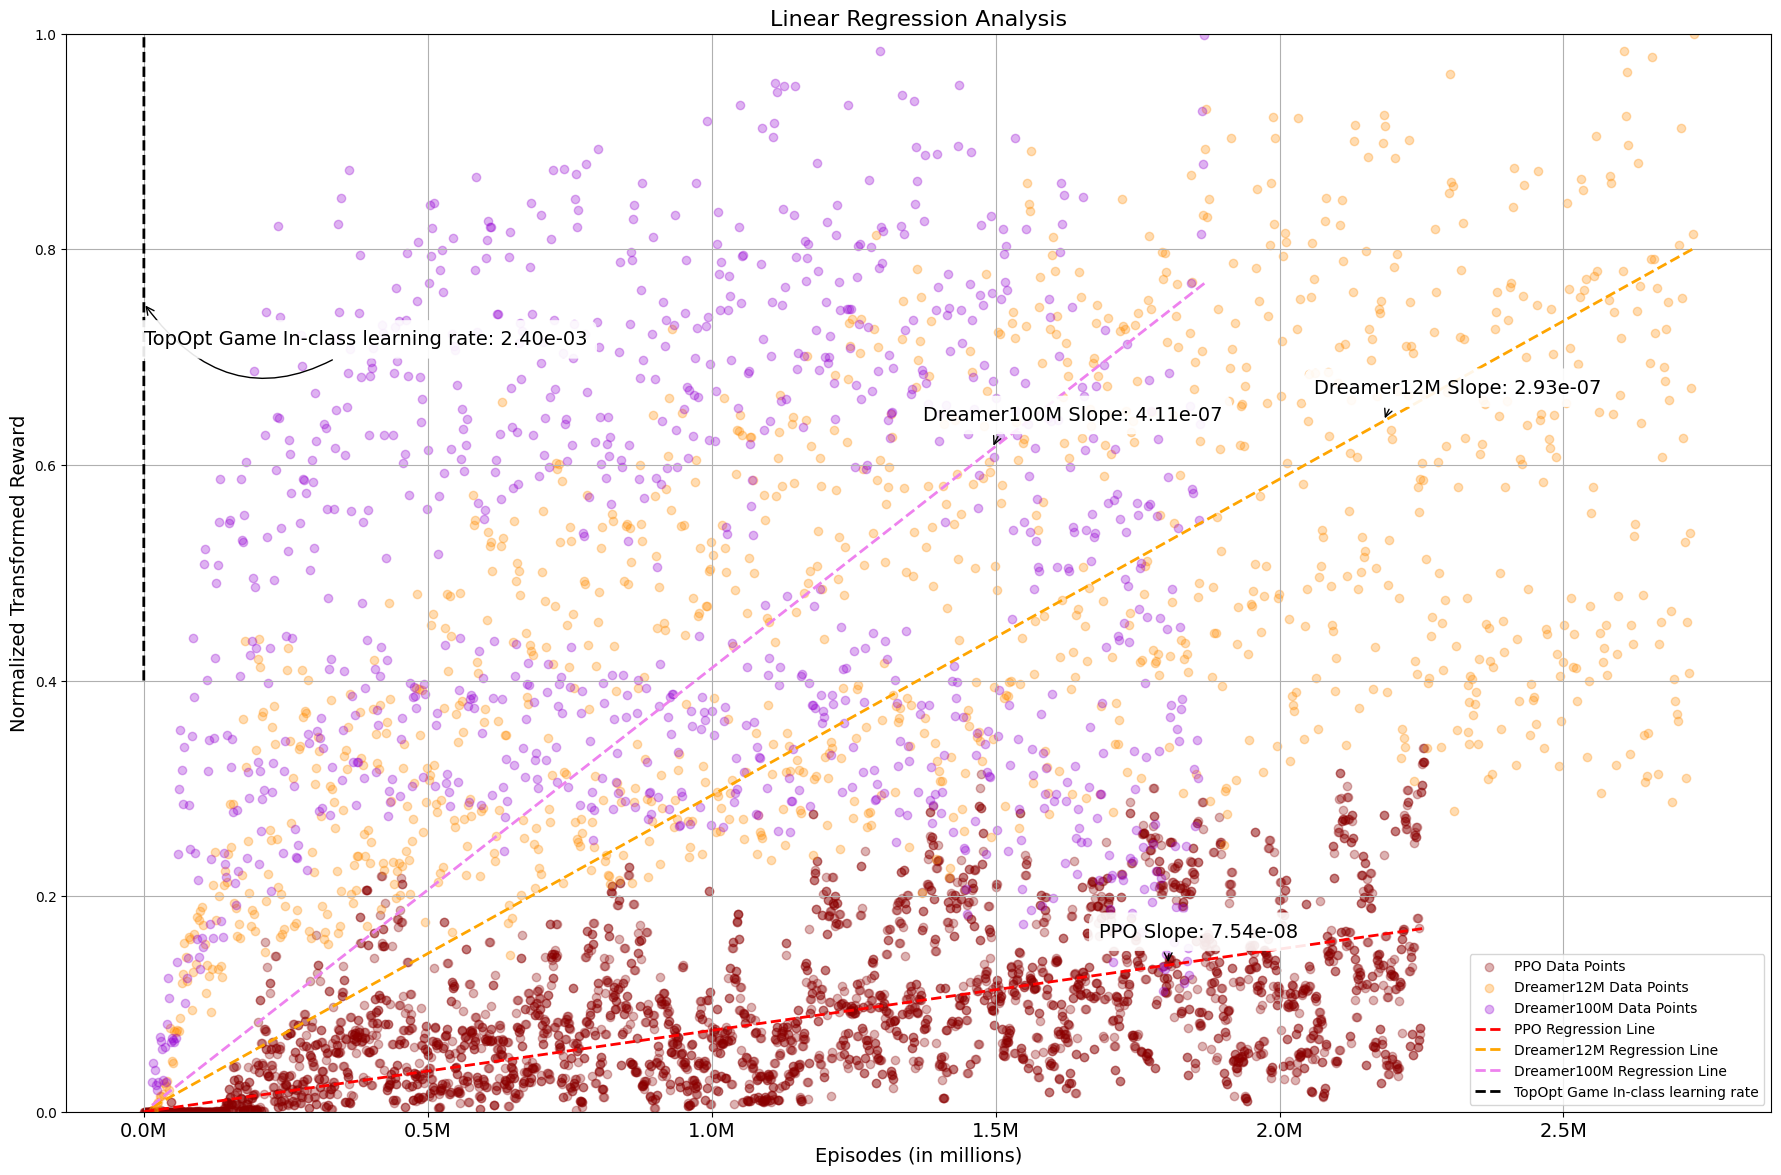

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Create separate DataFrames for PPO, Dreamer12M, and Dreamer100M
ppo_df = processed_merged_df[processed_merged_df['Normalized PPO'].notna()]
dreamer12M_df = processed_merged_df[processed_merged_df['Normalized Dreamer12M'].notna()]
dreamer100M_df = processed_merged_df[processed_merged_df['Normalized Dreamer100M'].notna()]

# Function to predict values for the regression lines
def predict_values(df, model, force_intercept):
    if force_intercept:
        return model.predict(df['Episodes'])
    else:
        return model.predict(sm.add_constant(df['Episodes']))

# Predict values for the regression lines
ppo_df['Predicted_PPO'] = predict_values(ppo_df, model_PPO, force_intercept)
dreamer12M_df['Predicted_Dreamer12M'] = predict_values(dreamer12M_df, model_dreamer12M, force_intercept)
dreamer100M_df['Predicted_Dreamer100M'] = predict_values(dreamer100M_df, model_dreamer100M, force_intercept)

# Slope and intercept from the paper
paper_slope = 0.0024
paper_intercept = 0.40

# Generate x-values for the paper line
paper_x = np.linspace(0, max(ppo_df['Episodes'].max(), dreamer12M_df['Episodes'].max(), dreamer100M_df['Episodes'].max()), 100)
paper_y = paper_slope * paper_x + paper_intercept

plt.figure(figsize=(22, 14))

# Plot scatter points for PPO with transparency
plt.scatter(ppo_df['Episodes'], ppo_df['Normalized PPO'], color='darkred', alpha=0.3, label='PPO Data Points')

# Plot scatter points for Dreamer12M with transparency
plt.scatter(dreamer12M_df['Episodes'], dreamer12M_df['Normalized Dreamer12M'], color='darkorange', alpha=0.3, label='Dreamer12M Data Points')

# Plot scatter points for Dreamer100M with transparency
plt.scatter(dreamer100M_df['Episodes'], dreamer100M_df['Normalized Dreamer100M'], color='darkviolet', alpha=0.3, label='Dreamer100M Data Points')

# Plot regression line for PPO
plt.plot(ppo_df['Episodes'], ppo_df['Predicted_PPO'], color='red', linestyle='--', linewidth=2, label='PPO Regression Line')

# Plot regression line for Dreamer12M
plt.plot(dreamer12M_df['Episodes'], dreamer12M_df['Predicted_Dreamer12M'], color='orange', linestyle='--', linewidth=2, label='Dreamer12M Regression Line')

# Plot regression line for Dreamer100M
plt.plot(dreamer100M_df['Episodes'], dreamer100M_df['Predicted_Dreamer100M'], color='violet', linestyle='--', linewidth=2, label='Dreamer100M Regression Line')

# Plot the line from the paper
plt.plot(paper_x, paper_y, color='black', linestyle='--', linewidth=2, label='TopOpt Game In-class learning rate')

# Calculate positions for the annotations
x_pos_ppo = ppo_df['Episodes'].max() * 0.8
y_pos_ppo = ppo_df['Predicted_PPO'].iloc[(ppo_df['Episodes'].searchsorted(x_pos_ppo))]

x_pos_dreamer12M = dreamer12M_df['Episodes'].max() * 0.8
y_pos_dreamer12M = dreamer12M_df['Predicted_Dreamer12M'].iloc[(dreamer12M_df['Episodes'].searchsorted(x_pos_dreamer12M))]

x_pos_dreamer100M = dreamer100M_df['Episodes'].max() * 0.8
y_pos_dreamer100M = dreamer100M_df['Predicted_Dreamer100M'].iloc[(dreamer100M_df['Episodes'].searchsorted(x_pos_dreamer100M))]

x_pos_paper = 0.22
y_pos_paper = 0.75

# Annotation for the slope of PPO in scientific notation
slope_ppo = model_PPO.params['Episodes'] if not force_intercept else model_PPO.params[0]
plt.annotate(f'PPO Slope: {slope_ppo:.2e}', xy=(x_pos_ppo, y_pos_ppo), textcoords="offset points", xytext=(-50,20),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=14,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope of Dreamer12M in scientific notation
slope_dreamer12M = model_dreamer12M.params['Episodes'] if not force_intercept else model_dreamer12M.params[0]
plt.annotate(f'Dreamer12M Slope: {slope_dreamer12M:.2e}', xy=(x_pos_dreamer12M, y_pos_dreamer12M), textcoords="offset points", xytext=(-50,20),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=14,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope of Dreamer100M in scientific notation
slope_dreamer100M = model_dreamer100M.params['Episodes'] if not force_intercept else model_dreamer100M.params[0]
plt.annotate(f'Dreamer100M Slope: {slope_dreamer100M:.2e}', xy=(x_pos_dreamer100M, y_pos_dreamer100M), textcoords="offset points", xytext=(-50,20),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=14,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope from the paper
plt.annotate(f'TopOpt Game In-class learning rate: {paper_slope:.2e}', xy=(x_pos_paper, min(1.0, y_pos_paper)), textcoords="offset points", xytext=(0,-30),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.5"), fontsize=14,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

plt.title('Linear Regression Analysis', fontsize=16)
plt.xlabel('Episodes (in millions)', fontsize=14)
plt.ylabel('Normalized Transformed Reward', fontsize=14)

# Set y-axis limits from 0.0 to 1.0
plt.ylim(0.0, 1.0)

plt.legend(fontsize=10)
plt.grid()

# Get current x-axis ticks and convert them to millions
current_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks], fontsize=14)
plt.savefig('plot.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
